<span style="color:lightblue; font-size:25px;">Upload Libraries</span>


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy

import warnings

warnings.filterwarnings("ignore")

<span style="color:lightblue; font-size:25px;">DATA PREPROCESSING</span>

In [2]:
train_datasets = "../input/brain-tumor-classification-mri/Training/"
test_datasets = "../input/brain-tumor-classification-mri/Testing/"

In [3]:
X_data, y_data = [], []
img_size = 150

# Load and preprocess data from training datasets
label_mapping = {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}

for label in os.listdir(train_datasets):
    img_files = os.listdir(os.path.join(train_datasets, label))
    for img_name in img_files:
        img_path = os.path.join(train_datasets, label, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (img_size, img_size))
            X_data.append(img_resized)
            y_data.append(label)

for label in os.listdir(test_datasets):
    img_files = os.listdir(os.path.join(test_datasets, label))
    for img_name in img_files:
        img_path = os.path.join(test_datasets, label, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (img_size, img_size))
            X_data.append(img_resized)
            y_data.append(label)

# Convert to numpy arrays
X_data = np.array(X_data) / 255.0

y_data = np.array([label_mapping[label] for label in y_data])

In [4]:
print("X Data boyu", X_data.shape)
print("y data boyu", y_data.shape)

X Data boyu (3264, 150, 150, 3)
y data boyu (3264,)


In [5]:
# One-hot encoding
y_data = to_categorical(y_data, num_classes=4)

In [6]:
print("X Data boyu", X_data.shape)
print("y data boyu", y_data.shape)

X Data boyu (3264, 150, 150, 3)
y data boyu (3264, 4)


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state = 42)

<span style="color:lightblue; font-size:25px;">Visualizations</span>

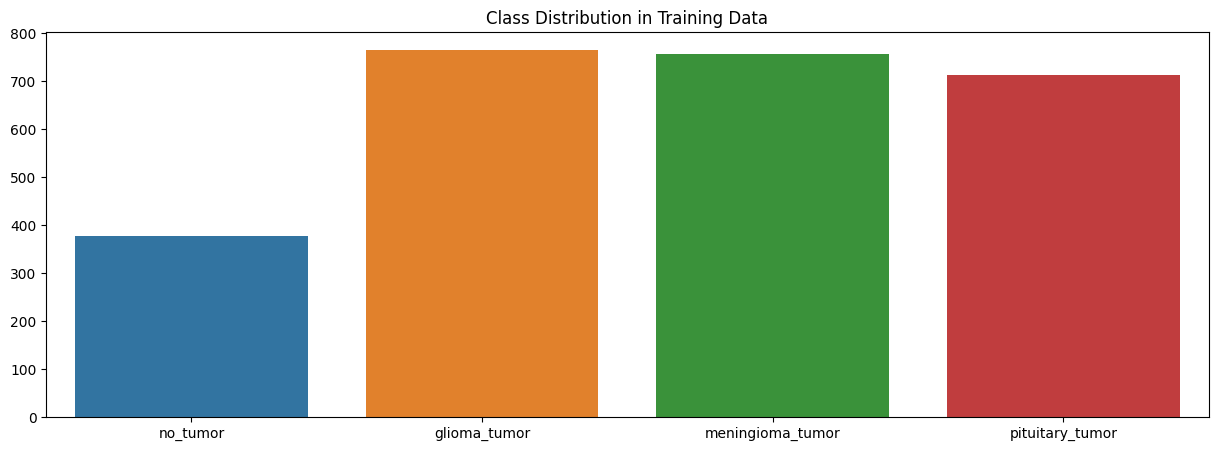

In [8]:
# Visualization: Class distribution
class_counts = np.sum(y_train, axis=0)
plt.figure(figsize=(15, 5))
sns.barplot(x=list(label_mapping.keys()), y=class_counts)
plt.title("Class Distribution in Training Data")
plt.show()

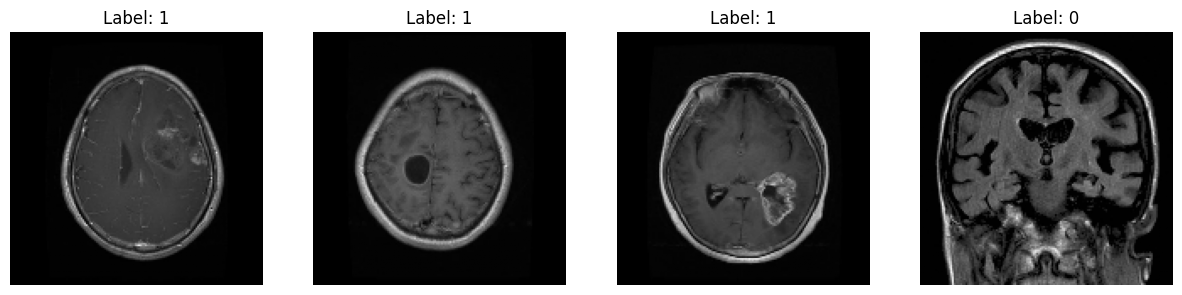

In [9]:
# Visualization: Display random 4 images from the training set
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"Label: {np.argmax(y_train[idx])}")
    ax.axis('off')
plt.show()

<span style="color:lightblue; font-size:25px;">Model Training</span>

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

datagen.fit(X_train)

In [11]:
# Model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         921,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,075,012 (4.10 MB)

 Trainable params: 1,074,884 (4.10 MB)

 Non-trainable params: 128 (512.00 B)

In [13]:
# Compile model 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1       # Erken durdurma hakkında bilgi ver
)

In [15]:
# Model training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=30, verbose=1,
                    callbacks=[early_stopping] 
                   )


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.3116 - loss: 1.3994 - val_accuracy: 0.2910 - val_loss: 1.3678
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.4903 - loss: 1.1381 - val_accuracy: 0.3124 - val_loss: 1.3421
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.5409 - loss: 1.0543 - val_accuracy: 0.4380 - val_loss: 1.1780
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.5796 - loss: 0.9792 - val_accuracy: 0.4165 - val_loss: 1.2457
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.6024 - loss: 0.9381 - val_accuracy: 0.2864 - val_loss: 1.5407
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.6167 - loss: 0.8918 - val_accuracy: 0.6646 - val_loss: 0.8226
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.6335 - loss: 0.8730 - val_accuracy: 0.6799 - val_loss: 0.7881
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.6415 - loss: 0.8281 - val_accuracy: 0.7014 - v

<span style="color:lightblue; font-size:25px;">Model Evaluate</span>

Text(0, 0.5, 'Loss')

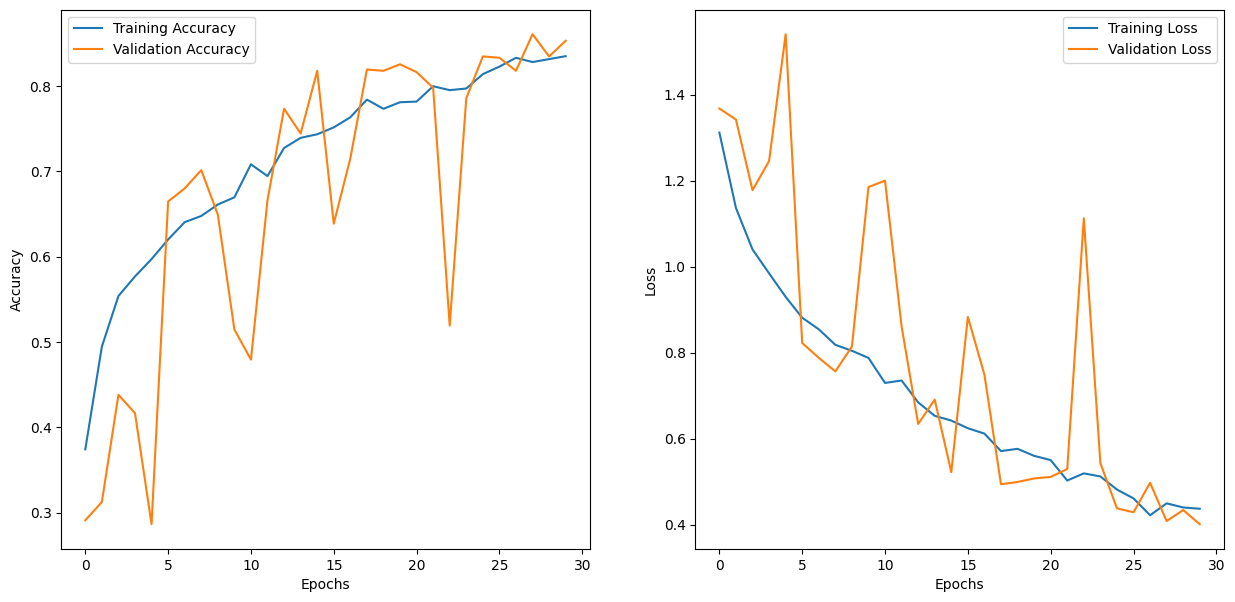

In [16]:
# Plot training history
epochs = range(30)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Accuracy plot
ax[0].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Loss plot
ax[1].plot(epochs, history.history['loss'], label='Training Loss')
ax[1].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 673ms/step


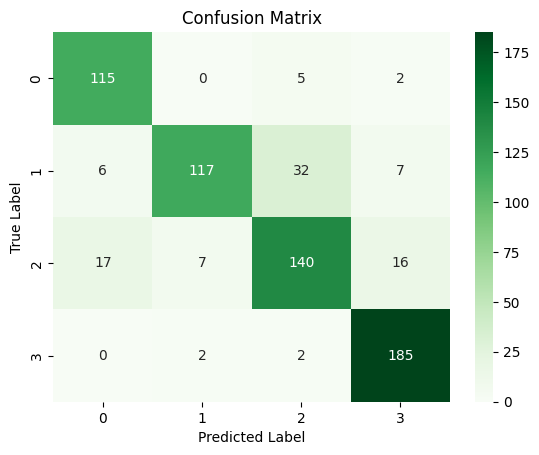

In [17]:
# Model evaluation
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Classification report
report = classification_report(Y_true, Y_pred_classes, target_names=list(label_mapping.keys()))
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

        no_tumor       0.83      0.94      0.88       122
    glioma_tumor       0.93      0.72      0.81       162
meningioma_tumor       0.78      0.78      0.78       180
 pituitary_tumor       0.88      0.98      0.93       189

        accuracy                           0.85       653
       macro avg       0.86      0.86      0.85       653
    weighted avg       0.86      0.85      0.85       653



In [19]:
# Test the model 

label_mapping = ["no_tumor", "pituitary_tumor", "glioma_tumor", "meningioma_tumor"] 

sample_images = [
    "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg",
    "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/4.jpg",
    "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (14).jpg",
    "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/2.jpg",
]

for img_path in sample_images:
    img = cv2.imread(img_path)
    
    if img is not None:
        img_resized = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
        img_resized = np.expand_dims(img_resized, axis=0)  

        predictions = model.predict(img_resized)

        predicted_class = np.argmax(predictions) 
        print(f"Image: {img_path}")
        print(f"Prediction: {predictions}")
        print(f"Predicted Class: {predicted_class} ({label_mapping[predicted_class]})\n")
    else:
        print(f"Error loading image: {img_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: /kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
Prediction: [[9.9853468e-01 9.5333776e-04 5.1151350e-04 4.2147636e-07]]
Predicted Class: 0 (no_tumor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /kaggle/input/brain-tumor-classification-mri/Training/no_tumor/4.jpg
Prediction: [[0.8883748  0.02798409 0.08223171 0.00140939]]
Predicted Class: 0 (no_tumor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (14).jpg
Prediction: [[9.9701321e-01 2.8771788e-03 1.0923762e-04 3.8047600e-07]]
Predicted Class: 0 (no_tumor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: /kaggle/input/brain-tumor-classification-mri/Training/no_tumor/2.jpg
Prediction: [[0.844897   0.09310562 0.06051503 0.00148237]]
Predicted Class: 0 (no_tumor)



In [20]:
loss_fn = CategoricalCrossentropy()
y_pred = model.predict(X_test)
loss_value = loss_fn(y_test, y_pred).numpy()

print(f"Cross-Entropy Loss in X test: {loss_value}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 695ms/step
Cross-Entropy Loss in X test: 0.4011608064174652
